# <img style="float: left; padding-right: 50px, width 45px"  src="https://miro.medium.com/max/1280/1*tHXPVLP294z8dcZwkL3wHw.png" width="250" height="50" > <br/><br/>
## TRON Bypass Rate Model (Daily, Network Level)
 
**Team: RST-A**<br/>
**Date**: Q1 2023<br/>

<hr style="height:2pt" >

In [59]:
# Install potentially missing packages in SageMaker

# import sys
# ! {sys.executable} -m pip install tensorflow
# ! {sys.executable} -m pip install shap
# ! {sys.executable} -m pip install keras
# ! {sys.executable} -m pip install graphviz
# ! {sys.executable} -m pip install pyathena
# ! {sys.executable} -m pip install snappy
# ! {sys.executable} -m pip install xgboost
# ! {sys.executable} -m pip install seaborn

In [60]:
import datetime
from datetime import timedelta

import matplotlib.pylab as plt
import seaborn as sns

import pandas as pd
import boto3
import os
import io
import numpy as np
import math
import time
import statsmodels.api as sm

import sys
import pyarrow
import snappy
import graphviz

from itertools import chain
from functools import reduce
from pyathena import connect
from os import path

import xgboost

### Defining Functions to Retrieve S3 Data and/or Query from Athena

In [61]:
# Establishing S3 Data Directory

data_dir = 's3://cotezach-prod/TRON_Bypass_Modelling/'

In [62]:
# Function to Directly Query Athena Tables

def athena_conn(query, s3_dir = 's3://aws-athena-query-results-038954691342-us-east-1/', region = 'us-east-1'):
    """Return a SQL query from Athena into a pandas dataframe."""
    
    # Define connection to Athena
    conn = connect(s3_staging_dir = s3_dir,
                   region_name = region)
    
    # Query Athena and return to df
    df = pd.read_sql(query, conn)
    
    return df

In [63]:
# Fetch from / Write to S3 Functions

def fetch_s3_from_file(path_to_file):
    
    client = boto3.client('s3')
    obj2 = client.get_object(Bucket = 'cotezach-prod', Key = path_to_file)
    df = pd.read_csv(obj2['Body'])
    return df


def write_results_s3(dataframe, sand_box, path):
    data_string = dataframe.to_csv()
    resource = boto3.resource('s3')
    object = resource.Object(sand_box, path) # Select folder and file name in your path in S3
    object.put(Body = data_string)

## Cleaning the Main TBR Dataframe

In [65]:
# Fetching Main TBR Dataframe
main_df = fetch_s3_from_file('TRON_Bypass_Modelling/TBR_model_data_raw.csv')
main_df = main_df.drop(['Unnamed: 0','ML_Accuracy'], axis=1)

# Converting pt_fc_date to Datetime
main_df.pt_fc_date = pd.to_datetime(main_df['pt_fc_date'])

# Replacing NaN Value for North America with "NA"
main_df.region.fillna('NA', inplace=True)

# main_df.head()
main_df.shape

(89723, 43)

In [66]:
# Data Cleaning to get rid of impossible values
main_df = main_df.replace(float("inf"), np.nan)
main_df = main_df.replace([np.inf, -np.inf], np.nan)

# Checking which sites are included in the Dataframe
# main_df.building.unique()

In [68]:
# Restricting the Main DF to Relevant Columns

# main_df = main_df[['region', 'building_type', 'drive_type', 'site', 'pt_fc_date',
#                    'pick_start', 'launch_year', 'site_maturity', 'total_stows',
#                    'hc_agreements', 'ml_accuracy', 'hc_audits', 'hc_count', 
#                    'lc_agreements', 'lc_audits', 'lc_count', 'multiple_events',
#                    'negative_stow_hint_violations', 'tron_bypass_rate', 'tron_ioa',
#                    'me_dpmo', 'me_pct', 'ids_accuracy', 'ib_volume', 'stow_hrs',
#                    'vet_hrs', 'stow_work_secs', 'stows_performed', 'IDS_work_secs',
#                    'IDS_stows_performed', 'pod_visits', 'units_per_face', 'tenure_per',
#                    'ids_takt', 'stow_gap_ms', 'stow_total_ms', 'stowgap', 'units', 'bins',
#                    'inventory_volume', 'gross_volume', 'gcu', 'acu', 'units_per_bin']]

In [69]:
# Chopping Early 2022 Out from NRT Dataframe (Unstable Metrics pre-Prime)

na_eu = main_df[main_df['region'].isin(['NA','EU'])]
nrt = main_df[(main_df['region'].isin(['NRT'])) & (main_df['pt_fc_date'] >= pd.to_datetime('2022-06-01'))]

main_df = pd.concat([na_eu, nrt], ignore_index = True)
main_df.shape

(88176, 43)

In [70]:
# Dropping Immature Sites (>120 Days since first transactions)

main_df = main_df[main_df['site_maturity'] == 1]
main_df.shape

(80041, 43)

In [71]:
# Checking Null % within each Column

print("Null Percentages by Column")
main_df.isnull().sum(axis = 0)/len(main_df) *100 

Null Percentages by Column


site                   0.000000
pt_fc_date             0.000000
total_stows            3.924239
hc_agreements          3.924239
hc_audits              3.924239
hc_count               3.924239
lc_agreements          3.924239
lc_audits              3.924239
lc_count               3.924239
multiple_events        3.924239
tron_bypass_rate       3.924239
tron_ioa               3.924239
me_dpmo                3.924239
ml_accuracy            3.924239
ids_accuracy           3.924239
me_pct                 3.924239
ib_volume              3.223348
stow_hrs               3.223348
vet_hrs                3.223348
stow_work_secs         3.223348
stows_performed        3.223348
IDS_work_secs          3.223348
IDS_stows_performed    3.223348
pod_visits             3.225847
units_per_face         3.225847
tenure_per             3.223348
ids_takt               4.376507
stow_gap_ms            2.157644
stow_total_ms          2.157644
stowgap                2.157644
units                  0.114941
bins    

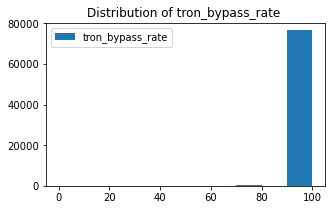

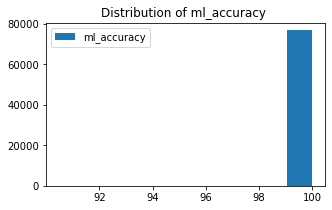

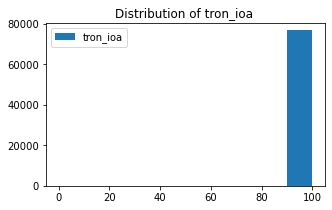

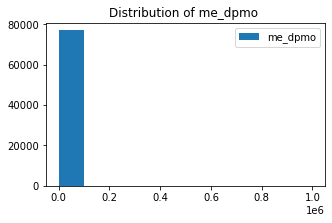

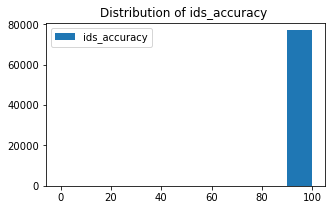

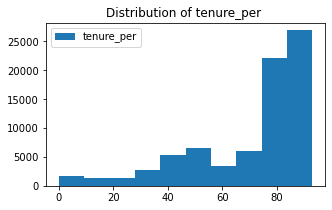

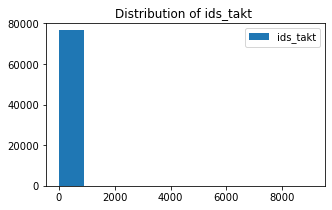

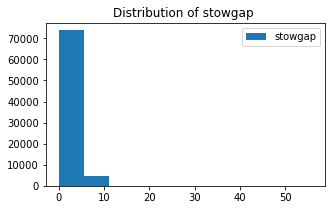

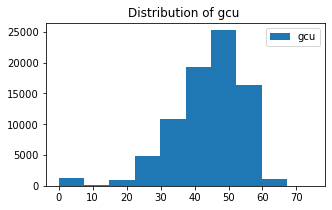

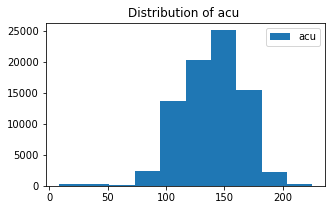

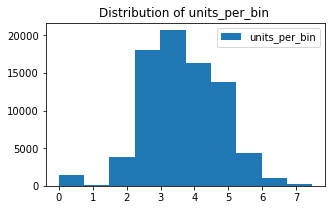

In [72]:
# Plotting Histograms to Determine Outlier Variables

for c in ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'stowgap', 'gcu', 'acu', 'units_per_bin']:
    
    fig = plt.figure(figsize=(5, 3))
    plt.hist(main_df[c], label=c) 
    plt.title(f"Distribution of {c} ")
    plt.legend()
    plt.show()

In [73]:
# Understanding the Distribution of these Variables

x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

main_df[x_vars].describe()

,tron_bypass_rate,ml_accuracy,tron_ioa,me_dpmo,ids_accuracy,tenure_per,ids_takt,units_per_face,stowgap,gcu,acu,units_per_bin
count,76900.000000,76900.000000,76900.000000,76900.000000,76900.000000,77461.000000,76538.000000,77459.000000,78314.000000,79949.000000,79932.000000,79949.000000
mean,97.700920,99.968885,98.941488,277.016035,99.917424,70.229184,15.461612,8.231870,2.368504,43.933100,139.055264,3.648909
std,1.791072,0.108095,1.292826,3614.265000,0.384969,21.210621,40.399632,2.565793,1.798823,10.602928,26.402020,1.122132
min,0.000000,90.476191,0.000000,0.000000,-0.700000,0.000000,0.000000,0.340048,0.000000,0.000053,8.104477,0.000000
25%,97.353667,99.961730,98.531751,172.352021,99.904664,56.818582,13.381382,6.412445,1.147792,38.171117,120.224473,2.849402
50%,97.881063,100.000000,99.131127,227.554074,99.943948,80.766476,15.061225,7.890119,1.879203,45.631765,141.416960,3.577622
75%,98.352194,100.000000,99.714286,310.951533,99.966108,85.146037,16.874460,9.781551,3.065765,51.629836,158.400539,4.455973
max,100.000000,100.000000,100.000000,1000000.000000,100.000000,93.032787,9072.899000,39.657837,55.956984,74.701864,225.565295,7.476528


In [74]:
# Setting Data Limits for the "Cleaned" Dataframe

# Scrubbing Data from main_df
df_clean = main_df

# IDS KPIs
min_tbr = 90.0
min_ml_accuracy = 99.7
min_ioa = 95.0
max_me_dpmo = 1200
min_ids_accuracy = 99.0

df_clean = df_clean[df_clean['tron_bypass_rate'] >= min_tbr]
df_clean = df_clean[df_clean['ml_accuracy'] >= min_ml_accuracy]
df_clean = df_clean[df_clean['tron_ioa'] >= min_ioa]
df_clean = df_clean[df_clean['me_dpmo'] <= max_me_dpmo]
df_clean = df_clean[df_clean['ids_accuracy'] >= min_ids_accuracy]

# Other Metrics
max_ids_takt = 40
max_podgap = 20
max_acu = 250

df_clean = df_clean[df_clean['ids_takt'] <= max_ids_takt]
df_clean = df_clean[df_clean['stowgap'] <= max_podgap]
df_clean = df_clean[df_clean['acu'] <= max_acu]

# Dropping Unnecessary Values
df_clean = df_clean.drop_duplicates()
df_clean = df_clean.dropna()

# Determining how much data was cut in cleaning
print(round((len(main_df)-len(df_clean))/len(main_df)*100,2), '% removed during cleaning')

11.11 % removed during cleaning


In [75]:
# Resetting Main DF to be the newly Cleaned DF

main_df = df_clean

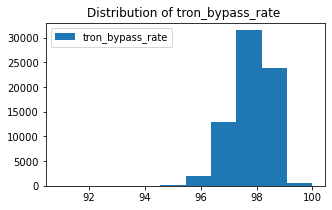

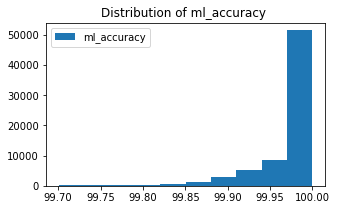

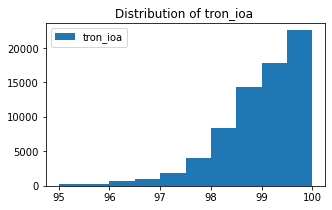

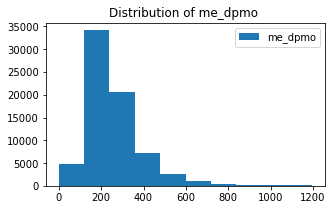

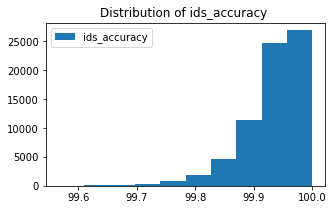

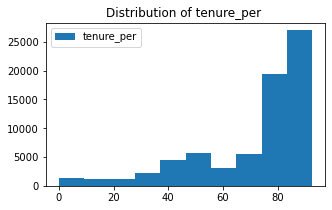

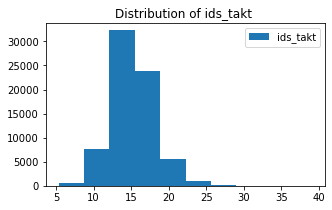

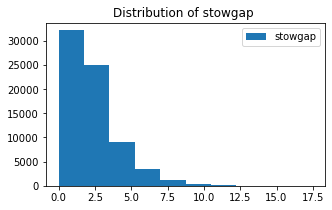

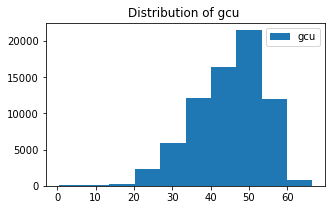

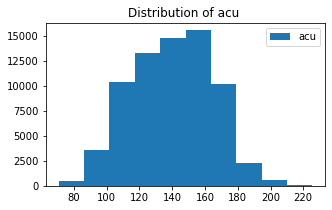

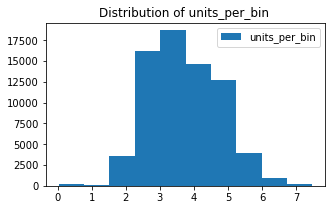

In [76]:
# Plotting Histograms following DF Cleaning (i.e. much more normal curves)

for c in ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'stowgap', 'gcu', 'acu', 'units_per_bin']:
    
    fig = plt.figure(figsize=(5,3))
    plt.hist(main_df[c], label=c) 
    plt.title(f"Distribution of {c} ")
    plt.legend()
    plt.show()

In [77]:
# Exporting a Clean CSV for Safe-Keeping

write_results_s3(main_df,'cotezach-prod','TRON_Bypass_Modelling/TBR_model_data_clean.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


## Variance Inflation Analysis (identifying correlated variables)

In [18]:
# Streamlined Feature Set, compiled here for coming Variance Inflation Analysis

# All Variables
y_vars = ['tron_bypass_rate']
x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

# Removed ML Accuracy (colinear with Multiple Events & IDS Accuracy)
# y_vars = ['tron_bypass_rate']
# x_vars = ['tron_bypass_rate', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
#           'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

In [19]:
# Exploring Covariance

from sklearn.preprocessing import OneHotEncoder

long_x_vars = main_df[x_vars].reset_index(drop=True)
df_no_na = long_x_vars.dropna()

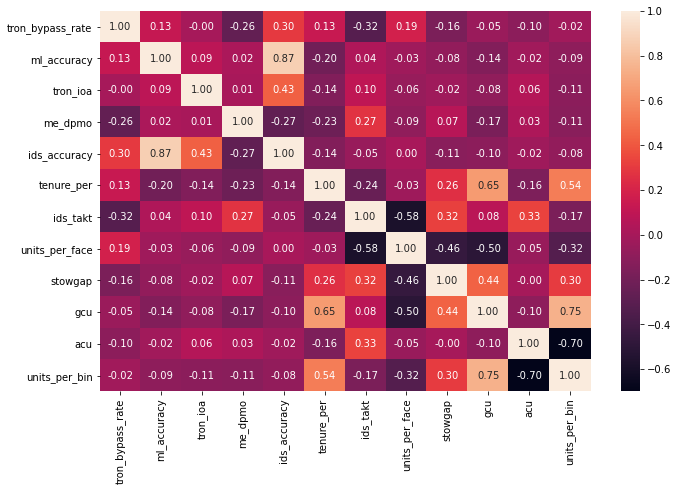

In [20]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()

X_std = stdsc.fit_transform(df_no_na)
covMatrix = np.cov(X_std.T)

plt.figure(figsize=(11, 7))
sns.heatmap(covMatrix, xticklabels = long_x_vars.columns, yticklabels = long_x_vars.columns, fmt = '.2f', annot = True)

plt.show()

In [21]:
# Best Practice is to remove variables that are correlated (or showing >5 VIF)
# Scanning all modelled features for Variance Inflation Factors:

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


X = add_constant(df_no_na[x_vars])
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index = X.columns)

# When dealing with VIFs > 5, getting rid of 1 of 2 high VIF factors should deflate the other

const               5.530752e+06
tron_bypass_rate    2.412686e+00
ml_accuracy         5.192856e+01
tron_ioa            1.104084e+01
me_dpmo             6.148863e+00
ids_accuracy        7.413762e+01
tenure_per          2.401105e+00
ids_takt            2.233674e+00
units_per_face      2.564819e+00
stowgap             1.464472e+00
gcu                 1.410807e+01
acu                 1.060514e+01
units_per_bin       2.412305e+01
dtype: float64

## Regression Performance Benchmarking

In [78]:
# Importing Modelling Packages

from numpy import loadtxt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [79]:
# Selecting Variables for Linear Regression (Attribution Exercise)

# All Variables
y_vars = ['tron_bypass_rate']
x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

In [80]:
# Creating Categorical Binary Variables (Region, Drive Type, Site Type)
enc = OneHotEncoder()

all_x_vars = main_df[x_vars].reset_index(drop=True)

categorical_vars = pd.DataFrame(enc.fit_transform(main_df[['region','drive_type']]).toarray())
categorical_vars.columns  = enc.get_feature_names(['Region','Drive'])

# categorical_vars = pd.DataFrame(enc.fit_transform(main_df[['region','drive_type','building_type']]).toarray())
# categorical_vars.columns  = enc.get_feature_names(['Region','Drive','Type'])

In [81]:
# Preparing Dataframe

df_no_na = main_df.dropna()
df_no_na.columns.unique()

# Shuffling the Main DF randomly for Regression Modelling
df_no_na = df_no_na.sample(frac=1).reset_index(drop=True)

In [82]:
# Testing the Three Main Variants of the TBR Model (and a global version)

# Global / Untouched
# model_raw = df_no_na

# North American ARS
model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['NA']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['NA']))]

# Europe ARS
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['EU']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['EU']))]

# J-POD FCs (Only use data after June 1st, 2022)
# model_raw = df_no_na[(df_no_na['site'].isin(['KIX5','QCB1','KIX6','TYO1','TYO4','TYO6','TYO7','TYO8','TYO9']))]

In [83]:
model_raw.shape

(41425, 43)

In [87]:
# Testing Margin of Error for Basic Regression

# model_data = pd.concat([model_raw[x_vars + ['pt_fc_date']].reset_index(drop=True), categorical_vars], axis = 1)
model_data = pd.concat([model_raw[x_vars + ['pt_fc_date']].reset_index(drop=True)], axis = 1)

train = model_data[model_data.pt_fc_date <= '2023-03-20']
test = model_data[model_data.pt_fc_date > '2023-03-20']

train = sm.add_constant(train)
test = sm.add_constant(test)

all_data = pd.concat([train,test])

# Determining the % of Data used to Test the Model
print(round((len(test)/(len(test)+len(train)))*100,2),'% Test Data')

4.91 % Test Data


In [88]:
# Calling the Model to Test
# X_train, y_train = train.drop(columns = ['tron_bypass_rate','pt_fc_date',
#                                          'Drive_H','Region_NA']), train['tron_bypass_rate']

# X_test, y_test = test.drop(columns = ['tron_bypass_rate','pt_fc_date',
#                                       'Drive_H','Region_NA']), test['tron_bypass_rate']

# Avoiding Categorical Variables (Region, Drive Type)
X_train, y_train = train.drop(columns = ['tron_bypass_rate','pt_fc_date']), train['tron_bypass_rate']

X_test, y_test = test.drop(columns = ['tron_bypass_rate','pt_fc_date']), test['tron_bypass_rate']

In [89]:
# Testing the Margin of Error
lin_model_tbr = sm.OLS(y_train, X_train).fit()
mae_tbr = mean_absolute_error(y_test,lin_model_tbr.predict(X_test))
mse_tbr = mean_squared_error(y_test,lin_model_tbr.predict(X_test))

print('Mean Average Error =', round(mae_tbr,3), '% TBR')
print('Mean Square Error =', round(mse_tbr,3), '% TBR')

Mean Average Error = 0.323 % TBR
Mean Square Error = 0.206 % TBR


In [90]:
# Printing the Entire, Global Model

print(lin_model_tbr.summary())

                            OLS Regression Results                            
Dep. Variable:       tron_bypass_rate   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     6722.
Date:                Wed, 12 Apr 2023   Prob (F-statistic):               0.00
Time:                        19:44:41   Log-Likelihood:                -19414.
No. Observations:               39389   AIC:                         3.885e+04
Df Residuals:                   39377   BIC:                         3.895e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -36.1439      4.824     -7.

In [91]:
# Setting all Date Columns to Timestamps

all_data['pt_fc_date'] = pd.to_datetime(all_data['pt_fc_date'])
train['pt_fc_date'] = pd.to_datetime(train['pt_fc_date'])
test['pt_fc_date'] = pd.to_datetime(test['pt_fc_date'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

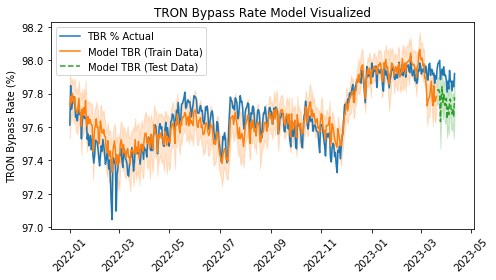

In [92]:
# Plotting Actuals vs. Model Performance

fig, ax = plt.subplots()
ax = sns.lineplot(all_data.pt_fc_date, all_data.tron_bypass_rate, label = 'TBR % Actual', ci = False)
ax = sns.lineplot(train.pt_fc_date, lin_model_tbr.predict(train.drop(columns = ['tron_bypass_rate', 'pt_fc_date'])), label = 'Model TBR (Train Data)')
ax = sns.lineplot(test.pt_fc_date, lin_model_tbr.predict(test.drop(columns = ['tron_bypass_rate', 'pt_fc_date'])), label = 'Model TBR (Test Data)', linestyle = 'dashed')

plt.title('TRON Bypass Rate Model Visualized')
fig.set_size_inches(7,4)

ax.set_ylabel('TRON Bypass Rate (%)')
ax.set_xlabel('')

#plt.ylim(160, 275)
plt.xticks(rotation=45)
fig.tight_layout()

## Creating TRON Bypass Rate Projections

### Step 1: Reconstruct Core Model

Set up the TBR Model and train it on a specific set of data.

In [108]:
# Selecting Variables for Linear Regression (Predictive Modelling)

# All Variables
y_vars = ['tron_bypass_rate']
x_vars = ['tron_bypass_rate', 'ml_accuracy', 'tron_ioa', 'me_dpmo', 'ids_accuracy',
          'tenure_per', 'ids_takt', 'units_per_face', 'stowgap', 'gcu', 'acu', 'units_per_bin']

In [109]:
# Creating Categorical Binary Variables (Region, Drive Type, Site Type)
enc = OneHotEncoder()

all_x_vars = main_df[x_vars].reset_index(drop=True)

categorical_vars = pd.DataFrame(enc.fit_transform(main_df[['region','drive_type']]).toarray())
categorical_vars.columns  = enc.get_feature_names(['Region','Drive'])

# categorical_vars = pd.DataFrame(enc.fit_transform(main_df[['region','drive_type','building_type']]).toarray())
# categorical_vars.columns  = enc.get_feature_names(['Region','Drive','Type'])

In [110]:
# Preparing Dataframe

df_no_na = main_df.dropna()
df_no_na.columns.unique()

# Shuffling the Main DF randomly for Regression Modelling
df_no_na = df_no_na.sample(frac=1).reset_index(drop=True)

In [111]:
# Selecting Model Variant (Region, Drive Type, Building Type)

# Global / Untouched
# model_raw = df_no_na

# North American ARS
model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['NA']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['NA']))]

# Europe ARS
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['EU']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['EU']))]

# J-POD FCs (Only use data after June 1st, 2022)
# model_raw = df_no_na[(df_no_na['site'].isin(['KIX5','QCB1','KIX6','TYO1','TYO4','TYO6','TYO7','TYO8','TYO9']))]

In [112]:
# Selecting Date Range to Train Model On
model_raw = model_raw[model_raw['pt_fc_date'] >= pd.to_datetime('2022-01-01')]

In [113]:
# How many rows of data are in this dataframe?
model_raw.shape

(41425, 43)

In [114]:
# Testing Margin of Error for Basic Regression

# model_data = pd.concat([model_raw[x_vars + ['pt_fc_date']].reset_index(drop=True), categorical_vars], axis = 1)
model_data = pd.concat([model_raw[x_vars + ['pt_fc_date']].reset_index(drop=True)], axis = 1)

train = model_data[model_data.pt_fc_date <= '2023-04-05'] # Train the Model on as much data as possible
test = model_data[model_data.pt_fc_date > '2023-04-05']

train = sm.add_constant(train)
test = sm.add_constant(test)

all_data = pd.concat([train,test])

# Determining the % of Data used to Test the Model
print(round((len(test)/(len(test)+len(train)))*100,2),'% Test Data')

1.33 % Test Data


In [115]:
# Calling the TRON Bypass Model

X_train, y_train = train.drop(columns = ['tron_bypass_rate','pt_fc_date']), train['tron_bypass_rate']
X_test, y_test = test.drop(columns = ['tron_bypass_rate','pt_fc_date']), test['tron_bypass_rate']

In [116]:
# Testing the Margin of Error
lin_model_tbr = sm.OLS(y_train, X_train).fit()
mae_tbr = mean_absolute_error(y_test,lin_model_tbr.predict(X_test))
mse_tbr = mean_squared_error(y_test,lin_model_tbr.predict(X_test))

print('Mean Average Error =', round(mae_tbr,3), '% TBR')
print('Mean Square Error =', round(mse_tbr,3), '% TBR')

Mean Average Error = 0.317 % TBR
Mean Square Error = 0.205 % TBR


### Step 2: Calculating Inputs for Monthly Output

In order to make predictions we need to set KPI expectations for model inputs, then weight the final predicted TBR by IB Volume % Split in an Excel template. Some general scenarios followed in the past:
- High Case Scenario: Nike Program Targets, Performance Metrics from last Month
- Base Case Scenario: Nike Program targets, Performance Metrics YTD
- Peak Scenario: Nike Program Targets, Peak Fullness, Historic Peak KPIs

In [117]:
# Select Region, Drive Type, Building Type

# Global / Untouched
# model_raw = df_no_na

# North American ARS
model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['NA']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['NA']))]

# Europe ARS
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['H'])) & (df_no_na['region'].isin(['EU']))]
# model_raw = df_no_na[(df_no_na['drive_type'].isin(['G'])) & (df_no_na['region'].isin(['EU']))]

# J-POD FCs (Only use data after June 1st, 2022)
# model_raw = df_no_na[(df_no_na['site'].isin(['KIX5','QCB1','KIX6','TYO1','TYO4','TYO6','TYO7','TYO8','TYO9']))]

In [118]:
# Setting Up Model DF
actuals = model_raw

In [119]:
# Select Date Range (Recent Actuals)

actuals = actuals[(actuals['pt_fc_date'] >= pd.to_datetime('2023-03-01')) &
                  (actuals['pt_fc_date'] <= pd.to_datetime('2023-04-05')) ]
# actuals.head()

actuals.columns

Index(['site', 'pt_fc_date', 'total_stows', 'hc_agreements', 'hc_audits',
       'hc_count', 'lc_agreements', 'lc_audits', 'lc_count', 'multiple_events',
       'tron_bypass_rate', 'tron_ioa', 'me_dpmo', 'ml_accuracy',
       'ids_accuracy', 'me_pct', 'ib_volume', 'stow_hrs', 'vet_hrs',
       'stow_work_secs', 'stows_performed', 'IDS_work_secs',
       'IDS_stows_performed', 'pod_visits', 'units_per_face', 'tenure_per',
       'ids_takt', 'stow_gap_ms', 'stow_total_ms', 'stowgap', 'units', 'bins',
       'inventory_volume', 'gross_volume', 'gcu', 'acu', 'units_per_bin',
       'region', 'building_type', 'drive_type', 'pick_start', 'launch_year',
       'site_maturity'],
      dtype='object')

In [120]:
# Aggregating Data Up to Singular Values
# You can Group by Any Permutations of Region, Drive, Building Type

actuals_agg = actuals[['region', 'total_stows', 'hc_agreements', 'ml_accuracy', 'hc_audits', 
       'hc_count', 'lc_agreements', 'lc_audits', 'lc_count', 'multiple_events', 'ib_volume', 'stow_hrs', 'vet_hrs', 
       'stow_work_secs', 'stows_performed', 'IDS_work_secs', 'IDS_stows_performed', 'pod_visits',
       'stow_gap_ms', 'stow_total_ms', 'bins', 'units', 'inventory_volume',
       'gross_volume']].groupby(['region']).sum().reset_index()

actuals_agg.head()

,region,total_stows,hc_agreements,ml_accuracy,hc_audits,hc_count,lc_agreements,lc_audits,lc_count,multiple_events,...,stows_performed,IDS_work_secs,IDS_stows_performed,pod_visits,stow_gap_ms,stow_total_ms,bins,units,inventory_volume,gross_volume
0,NA,1.327206e+09,5268024.0,402928.676586,5269507.0,1.301622e+09,1615945.0,1637160.0,23378671.0,260876.0,...,7.093040e+10,9.627702e+11,7.092265e+10,6.976689e+09,2.849928e+11,1.615054e+13,576703992.0,1.483404e+09,2.302677e+11,6.593413e+11


In [121]:
# Recalculating Key Metrics for Model Input

# IDS KPIs
actuals_agg['tron_bypass_rate'] = actuals_agg['hc_count'] / actuals_agg['total_stows']
actuals_agg['tron_ioa'] = actuals_agg['lc_agreements'] / actuals_agg['lc_audits']
actuals_agg['me_dpmo'] = actuals_agg['multiple_events'] / actuals_agg['total_stows'] *1000000
actuals_agg['ml_accuracy'] = actuals_agg['hc_agreements'] / actuals_agg['hc_audits']

# IDS Accuracy
actuals_agg['ids_accuracy'] = (actuals_agg['tron_bypass_rate'] * actuals_agg['ml_accuracy'] + 
                              (1 - actuals_agg['tron_bypass_rate']) * 
                               actuals_agg['tron_ioa'] - actuals_agg['me_dpmo']/1000000) *100

# Scaling Up IDS KPIs
actuals_agg['tron_bypass_rate'] = actuals_agg['tron_bypass_rate'] *100
actuals_agg['tron_ioa'] = actuals_agg['tron_ioa'] *100
actuals_agg['ml_accuracy'] = actuals_agg['ml_accuracy'] *100
actuals_agg['me_pct'] = actuals_agg['multiple_events'] / actuals_agg['total_stows'] *100 # Creating a stable ME % metric

# Stow Metrics KPIs
actuals_agg['tenure_per'] = actuals_agg['vet_hrs'] / actuals_agg['stow_hrs'] *100
actuals_agg['ids_takt'] = actuals_agg['IDS_work_secs'] / actuals_agg['IDS_stows_performed']
actuals_agg['units_per_face'] = actuals_agg['ib_volume'] / actuals_agg['pod_visits']

# Stow Podgap
actuals_agg['stowgap'] = actuals_agg['stow_gap_ms'] / actuals_agg['stow_total_ms'] *100

# Inventory Metrics
actuals_agg['gcu'] = actuals_agg['inventory_volume'] / actuals_agg['gross_volume'] *100
actuals_agg['acu'] = actuals_agg['inventory_volume'] / actuals_agg['units']
actuals_agg['units_per_bin'] = actuals_agg['units'] / actuals_agg['bins']

In [122]:
# Displaying Calculated Metrics

actuals_agg[x_vars]

,tron_bypass_rate,ml_accuracy,tron_ioa,me_dpmo,ids_accuracy,tenure_per,ids_takt,units_per_face,stowgap,gcu,acu,units_per_bin
0,98.072362,99.971857,98.704158,196.560327,99.927764,62.328707,13.574933,10.166522,1.764602,34.923896,155.229242,2.57221


In [55]:
# ORIGINAL EXAMPLE

# # Creating Model Input with Aggreated KPIs (lead with 1 for Constant, ordered same as x_vars)
# jan23 = np.array([[1, 99.974983, 99.18, 199, 99.94, 82.79, 14.51, 10.16, 2.27, 41.81, 155.61, 3.05]])

# # Adding Additional Inputs with Historic Deltas (Example: GCU rises steadily in Q1 following Peak)
# feb23 = np.array([[1, 99.97498, 99.18, 199, 99.94, 82.79, 14.51, 10.16, 2.27, 42.50, 155.61, 3.1]]) # +0.7 GCU, +0.05 Units/Bin
# mar23 = np.array([[1, 99.97498, 99.18, 199, 99.94, 82.79, 14.51, 10.16, 2.27, 44.00, 155.61, 3.2]]) # +1.5 GCU, +0.15 Units/Bin

# # Bringing all Q1 Months Together
# q1_23 = np.concatenate([jan23, feb23, mar23], axis = 0)

In [193]:
# NACF Hercules Remainder 2023

# Creating Model Inputs with Aggreated KPIs (lead with 1 for Constant, ordered same as x_vars)
apr23 = np.array([[1, 99.986, 98.803, 202, 99.940, 63.86, 13.76, 9.91, 1.86, 36.05, 153.03, 2.62]]) # April '23 Actuals
may23 = np.array([[1, 99.986, 98.803, 202, 99.940, 65.00, 13.70, 10.10, 1.90, 38.20, 153.03, 2.80]]) # Rising GCU, Tenure
jun23 = np.array([[1, 99.986, 98.803, 202, 99.940, 65.00, 13.50, 10.10, 2.30, 42.50, 150.00, 2.90]]) # GCU Spike pre-PD

jul23 = np.array([[1, 99.986, 98.190, 220, 99.927, 65.00, 15.50, 7.80, 1.90, 45.20, 160.50, 3.42]]) # PRIME DAY
aug23 = np.array([[1, 99.986, 98.605, 210, 99.936, 65.00, 13.50, 10.10, 2.30, 43.70, 155.50, 3.10]]) # Post-Prime, less GCU
sept23 = np.array([[1, 99.986, 98.605, 210, 99.936, 65.00, 13.50, 10.10, 2.30, 44.00, 155.50, 3.10]])

oct23 = np.array([[1, 99.986, 98.310, 250, 99.930, 65.00, 15.50, 7.80, 1.90, 45.00, 160.50, 3.42]])
nov23 = np.array([[1, 99.988, 98.315, 250, 99.929, 65.00, 15.50, 7.80, 1.90, 48.00, 158.50, 3.50]]) # Heavy IB Peak
dec23 = np.array([[1, 99.986, 98.300, 250, 99.930, 65.00, 15.50, 7.80, 1.90, 45.00, 160.50, 3.20]]) # OB Peak (low pressure)

# Bringing all Q1 Months Together
nacf_h_23 = np.concatenate([apr23, may23, jun23, jul23, aug23, sept23, oct23, nov23, dec23], axis = 0)

NOTE: The example above is based on Q1, 2023 post-peak. Prime & Peak Scenarios should be handled differently, using more exact figures than "off-Peak" months in Q1, Q2, and Q3 which are more subjective.

- For the month of Prime Day (July, typically) use aggregated KPI inputs from October of the previous year.
- Similarly, for the months of October and November, use aggregated KPIs from those respective months the year prior
- For December, use only data prior to 12/23 from the year prior (end of Peak)

### Step 3: Generating Month-by-Month TBR Outputs

Now, with our inputs set, we can run the pre-trained model on them to get our TBR figures.

In [194]:
# Recalling our static inputs created above
Xnew = nacf_h_23

# Recalling our Linear Model
model = lin_model_tbr

# Make Predictions
ynew = model.predict(Xnew)
    
for i in range(len(Xnew)):
    print("Predicted TBR = %s" % np.array([ynew[i]]))

Predicted TBR = [98.05624916]
Predicted TBR = [98.01851166]
Predicted TBR = [98.14124095]
Predicted TBR = [97.76635346]
Predicted TBR = [98.01452793]
Predicted TBR = [98.02495023]
Predicted TBR = [97.8798969]
Predicted TBR = [97.8406121]
Predicted TBR = [98.02873014]
